In [4]:
import tensorflow as tf
import numpy as np
#tf.config.list_physical_devices('GPU')
width = 224
height = 224

data_X_train = np.load("data/X_train.npy", allow_pickle=True)
data_y_train = np.load("data/y_train.npy", allow_pickle=True)
data_labels_train = np.load("data/labels_train.npy", allow_pickle=True)
#data_X_test = np.load("data/X_test.npy")
#data_y_test = np.load("data/y_test.npy")
print(data_X_train.shape)
print(data_y_train.shape)
print(data_labels_train.shape)


(33402, 128, 128, 1)
(33402, 6, 4)
(33402, 6)


In [5]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train_bboxes, y_val_bboxes, y_train_labels, y_val_labels = train_test_split(
    data_X_train, data_y_train, data_labels_train,
    test_size=0.2,
    random_state=5,
    shuffle=True
)
data_X_train = None
data_y_train = None
data_labels_train = None


In [6]:
ds_train = tf.data.Dataset.from_tensor_slices((X_train, {"bboxes": y_train_bboxes, "classes": y_train_labels}))
X_train = None
y_train_bboxes = None
y_train_labels = None
ds_val = tf.data.Dataset.from_tensor_slices((X_val, {"bboxes": y_val_bboxes, "classes": y_val_labels}))
X_val = None
y_val_bboxes = None
y_val_labels = None
ds_train = ds_train.shuffle(buffer_size=10000).batch(64).prefetch(tf.data.AUTOTUNE)
ds_val = ds_val.batch(64).prefetch(tf.data.AUTOTUNE)

2025-11-28 22:54:13.609356: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 1751187456 exceeds 10% of free system memory.
2025-11-28 22:54:16.097092: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 1751187456 exceeds 10% of free system memory.


In [146]:
def lr_schedule(epoch):
    if epoch < 5:
        return 1e-5 + epoch * (1e-3 - 1e-4) / 5
    elif epoch < 15:
        return 1e-3
    elif epoch < 25:
        return 5e-4
    elif epoch < 30:
        return 1e-5
    else:
        return 1e-6
# TODO
def predModel(input_shape=(128,128,1), num_classes = 11, max_digits = 6):
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Conv2D(32, (3,3), padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Conv2D(64, (3,3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Conv2D(128, (3,3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Conv2D(256, (3,3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Conv2D(512, (3,3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    #BBOX
    bbox = tf.keras.layers.Dense(128, activation='relu')(x)
    bbox = tf.keras.layers.Dropout(0.1)(bbox)
    bbox = tf.keras.layers.Dense(max_digits * 4)(bbox)
    bbox_output = tf.keras.layers.Reshape((max_digits, 4), name="bboxes")(bbox)

    #CLASSIFICATION
    cls = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    cls = tf.keras.layers.Dropout(0.5)(cls)
    cls = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    cls = tf.keras.layers.Dropout(0.5)(cls)
    cls = tf.keras.layers.Dense(max_digits * num_classes, activation='softmax')(cls)
    cls_output = tf.keras.layers.Reshape((max_digits, num_classes), name="classes")(cls)

    return tf.keras.Model(inputs, [bbox_output, cls_output])

model = predModel()
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss={
        "bboxes": "huber",
        "classes": "sparse_categorical_crossentropy"
    },
    metrics={
        "bboxes": ["mse"],
        "classes": ["accuracy"]
    },
)


model.fit(
    ds_train,
    epochs=70,
    validation_data=ds_val,
    callbacks = [
        tf.keras.callbacks.LearningRateScheduler(lr_schedule),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_classes_loss', factor=0.3, patience=3,min_lr=1e-5, mode='min'),
        tf.keras.callbacks.EarlyStopping(monitor='val_classes_accuracy', patience=10, restore_best_weights=True, mode='max'),
        tf.keras.callbacks.EarlyStopping(monitor='val_bboxes_mse', patience=7, restore_best_weights=True, mode='min')
    ]
)




Epoch 1/70
418/418 ━━━━━━━━━━━━━━━━━━━━ 25s 44ms/step - bboxes_loss: 0.0307 - bboxes_mse: 0.0617 - classes_accuracy: 0.5009 - classes_loss: 1.7507 - loss: 1.8021 - val_bboxes_loss: 0.0120 - val_bboxes_mse: 0.0240 - val_classes_accuracy: 0.6520 - val_classes_loss: 1.2568 - val_loss: 1.2889 - learning_rate: 1.0000e-05
Epoch 2/70
418/418 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - bboxes_loss: 0.0057 - bboxes_mse: 0.0115 - classes_accuracy: 0.6686 - classes_loss: 1.0876 - loss: 1.1119 - val_bboxes_loss: 0.0069 - val_bboxes_mse: 0.0138 - val_classes_accuracy: 0.6869 - val_classes_loss: 0.9791 - val_loss: 1.0034 - learning_rate: 1.9000e-04
Epoch 3/70
418/418 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - bboxes_loss: 0.0044 - bboxes_mse: 0.0087 - classes_accuracy: 0.6932 - classes_loss: 0.9656 - loss: 0.9866 - val_bboxes_loss: 0.0048 - val_bboxes_mse: 0.0096 - val_classes_accuracy: 0.7016 - val_classes_loss: 0.9126 - val_loss: 0.9334 - learning_rate: 3.7000e-04
Epoch 4/70
418/418 ━━━━━━━━━━━━━━━━━━━━ 12s 28

In [147]:
results = model.evaluate(ds_val)
print(results)
print('Test loss: %.4f accuracy: %.4f' % (results[2], results[4]))

105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - bboxes_loss: 0.0017 - bboxes_mse: 0.0033 - classes_accuracy: 0.8808 - classes_loss: 0.4091 - loss: 0.4302
[0.4301951825618744, 0.001653027138672769, 0.4091285467147827, 0.003308911109343171, 0.880831241607666]
Test loss: 0.4091 accuracy: 0.8808


In [148]:
data_X_test = np.load("data/X_test.npy", allow_pickle=True)
data_y_test = np.load("data/y_test.npy", allow_pickle=True)
data_labels_test = np.load("data/labels_test.npy", allow_pickle=True)
print(data_X_test.shape)
print(data_y_test.shape)
print(data_labels_test.shape)
ds_test = tf.data.Dataset.from_tensor_slices((data_X_test, {"bboxes": data_y_test, "classes": data_labels_test}))
ds_test = ds_test.batch(64).prefetch(tf.data.AUTOTUNE)


(13068, 128, 128, 1)
(13068, 6, 4)
(13068, 6)


In [149]:
results = model.evaluate(ds_test)
print(results)
print('Test loss: %.4f accuracy: %.4f' % (results[2], results[4]))
data_X_test = None
data_y_test = None
data_labels_test = None
ds_test = None

205/205 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - bboxes_loss: 0.0028 - bboxes_mse: 0.0057 - classes_accuracy: 0.8424 - classes_loss: 0.5916 - loss: 0.6131
[0.6130827069282532, 0.002834540093317628, 0.5916111469268799, 0.005674796644598246, 0.8423886299133301]
Test loss: 0.5916 accuracy: 0.8424


In [150]:
model.save('models/svhnModel.keras')

dict_keys(['bboxes_loss', 'bboxes_mse', 'classes_accuracy', 'classes_loss', 'loss', 'val_bboxes_loss', 'val_bboxes_mse', 'val_classes_accuracy', 'val_classes_loss', 'val_loss', 'learning_rate'])


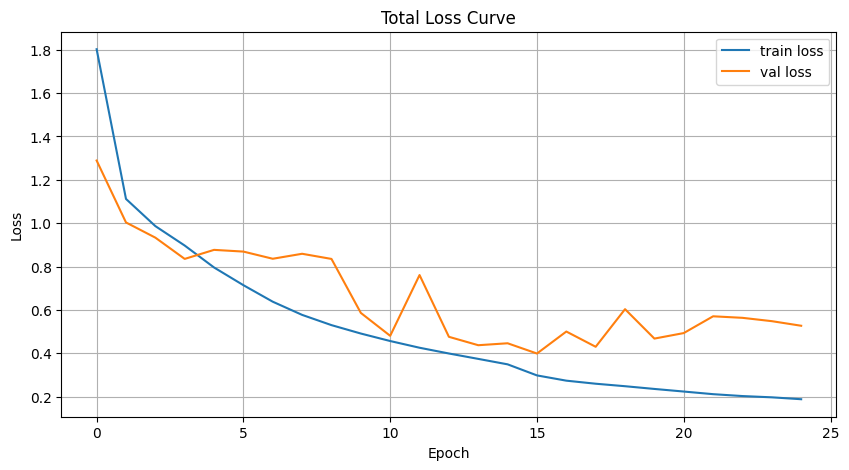

In [151]:
print(model.history.history.keys())
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(model.history.history['loss'], label = 'train loss')
plt.plot(model.history.history['val_loss'], label = 'val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Total Loss Curve')
plt.legend()
plt.grid()
plt.show()

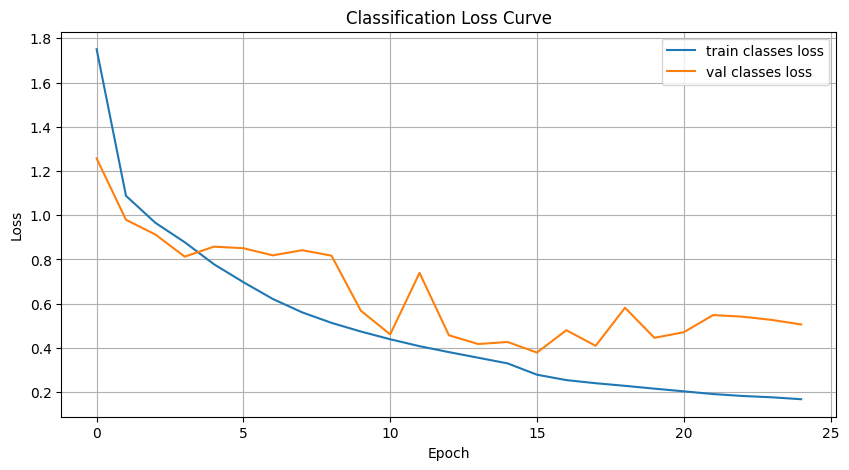

In [152]:
plt.figure(figsize=(10,5))
plt.plot(model.history.history['classes_loss'], label = 'train classes loss')
plt.plot(model.history.history['val_classes_loss'], label = 'val classes loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Classification Loss Curve')
plt.legend()
plt.grid()
plt.show()

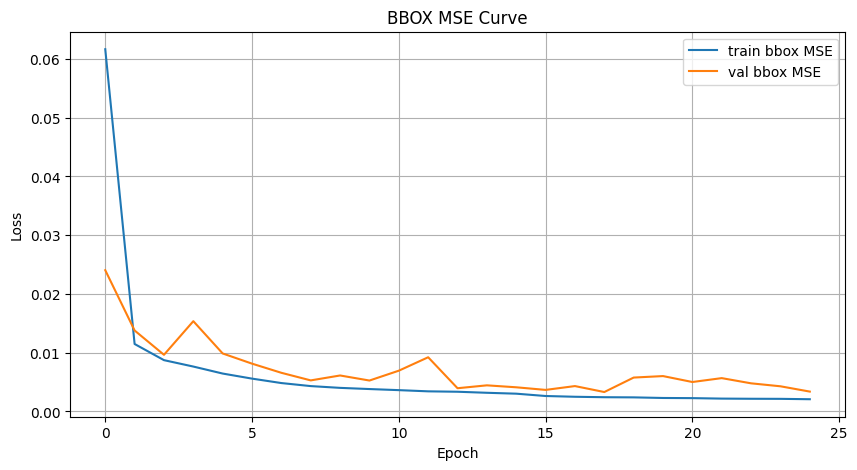

In [153]:
plt.figure(figsize=(10,5))
plt.plot(model.history.history['bboxes_mse'], label = 'train bbox MSE')
plt.plot(model.history.history['val_bboxes_mse'], label = 'val bbox MSE')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('BBOX MSE Curve')
plt.legend()
plt.grid()
plt.show()


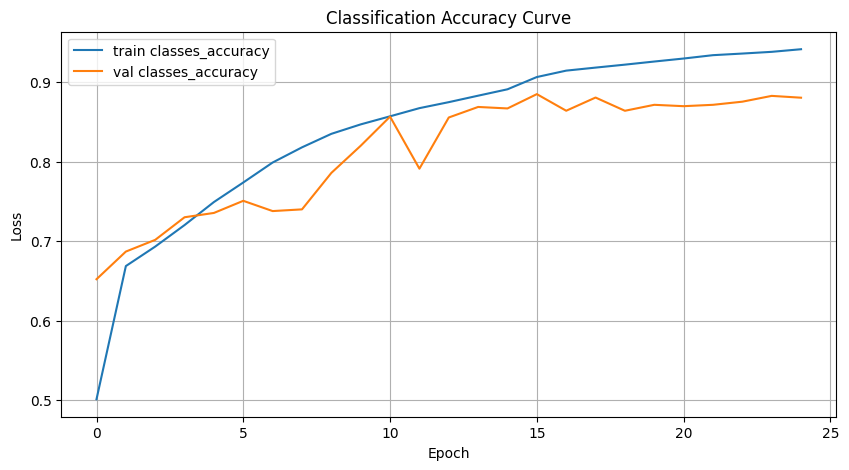

In [154]:
plt.figure(figsize=(10,5))
plt.plot(model.history.history['classes_accuracy'], label = 'train classes_accuracy')
plt.plot(model.history.history['val_classes_accuracy'], label = 'val classes_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Classification Accuracy Curve')
plt.legend()
plt.grid()
plt.show()


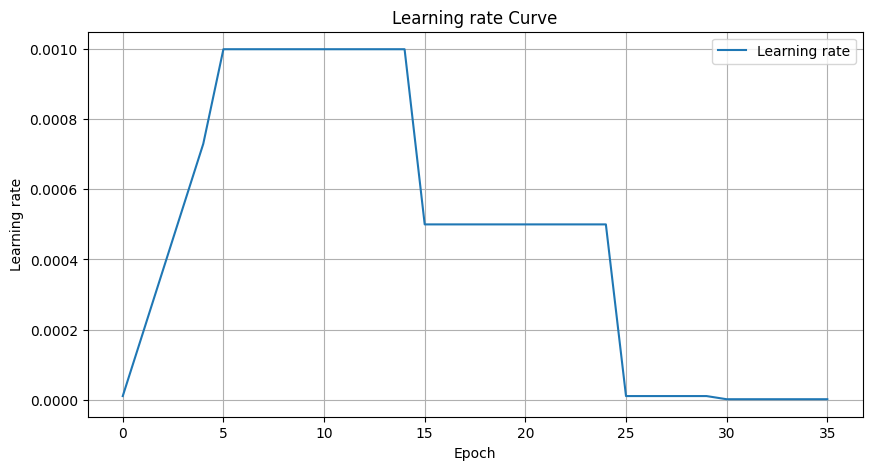

In [145]:
plt.figure(figsize=(10,5))
plt.plot(model.history.history['learning_rate'], label = 'Learning rate')
plt.xlabel('Epoch')
plt.ylabel('Learning rate')
plt.title('Learning rate Curve')
plt.legend()
plt.grid()
plt.show()